## PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week 4 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this Kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader).
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu).

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you of how to use PyTorch low- and high-level core. You can install it from [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like TensorFlow/Theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously: symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data. In PyTorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: PyTorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b).

Let's dive into it!

In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [disclaimer](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__.

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

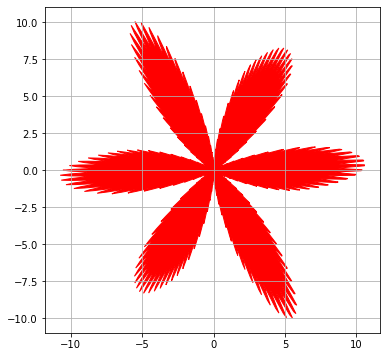

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# Compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) \
      * (1 + 0.01 * torch.cos(24 * theta)) \
      * (0.5 + 0.05 * torch.cos(200 * theta)) \
      * (10 + torch.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x, y) to plot them
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the DataLoader

In [3]:
from torch import nn
from torch.nn import functional as F

In [4]:
!wget -q https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/week01_General_recap_and_vanishng_gradients/notmnist.py -ncc

In [5]:
from notmnist import load_notmnist

X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [6]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small',
                 letters='ABCDEFGHIJ',
                 transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path,
                                                     letters=letters,
                                                     test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Load image as ndarray type (Height * Width * Channels).
        # Be carefull when converting dtype to np.uint8
        # (unsigned integer from 0 to 255).
        # In this example, we don't use ToTensor() method
        # of torchvision.transforms so you can convert numpy ndarray shape
        # to tensor in PyTorch (H, W, C) --> (C, H, W).
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [8]:
# We can access and get data with index by __getitem__(index):
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [9]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

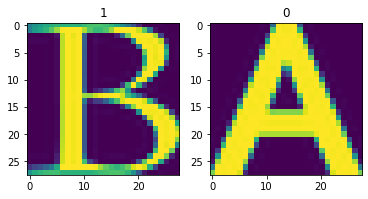

In [10]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [11]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using `iter()` function.

In [12]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data with `next()` method.

In [13]:
images, labels = train_iter.next()

print(f"Images shape on batch size = {images.size()}")
print(f"Labels shape on batch size = {labels.size()}")

Images shape on batch size = torch.Size([8, 28, 28, 1])
Labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/andyst/anaconda3/envs/lab/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


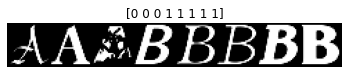

In [14]:
# make_grid takes tensor as argument.
# tensor: (batchsize, channels, height, width).
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [15]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [16]:
img, lab = train_dataset_with_transform.__getitem__(0)

print(f"Images shape on batch size = {images.size()}")

Images shape on batch size = torch.Size([8, 28, 28, 1])


In [17]:
train_loader_tr = DataLoader(train_dataset_with_transform,
                             batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print(f"Images shape on batch size = {images.size()}")
print(f"Labels shape on batch size = {labels.size()}")

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Images shape on batch size = torch.Size([8, 1, 28, 28])
Labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/andyst/anaconda3/envs/lab/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


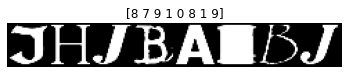

In [18]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`:

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```

This function can convert some images by order within `__call__` method.

In [19]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [20]:
a = Flatten()

In [21]:
a(img).shape

torch.Size([784])

In [22]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting it all together

In [23]:
import time

from IPython.display import clear_output

In [24]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset),
                            size=int(ratio * len(dataset)),
                            replace=False)

In [26]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"Dataset size: {len(dataset)}, " \
      f"labels size: {np.unique(dataset.dataset.labels)}.")

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
Dataset size: 3744, labels size: [0 1 2 3 4 5 6 7 8 9].


In [27]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset,
                       [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"Training size: {len(train_dataset)}.")
print(f"Validation size: {len(val_dataset)}.")

Training size: 2996.
Validation size: 748.


In [28]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [29]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print(f"Images shape on batch size = {images.size()}.")
print(f"Labels shape on batch size = {labels.size()}.")

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Images shape on batch size = torch.Size([32, 784]).
Labels shape on batch size = torch.Size([32]).


In [30]:
loss_func = nn.CrossEntropyLoss()

In [31]:
# Create the model again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout/batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calculate gradients,
            # perform optimizer step and zero grads
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout/use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                ep_val_loss.append(loss.item())
                pred_labels = torch.argmax(y_pred, dim=-1)
                accuracy_score = np.mean(
                    pred_labels.cpu().numpy() == y_batch.cpu().numpy()
                )
                ep_val_accuracy.append(accuracy_score)

        # print the results for this epoch:
        clear_output()
        print(f"Epoch {epoch + 1} of {n_epochs} took " \
              f"{time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\tTraining loss: {train_loss[-1]:.6f}")
        print(f"\tValidation loss: {val_loss[-1]:.6f}")
        print(f"\tValidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [33]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 30 of 30 took 0.087s
	Training loss: 1.557305
	Validation loss: 1.615460
	Validation accuracy: 0.864


In [34]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='Train')
    axes[0].plot(val_loss, label='Validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

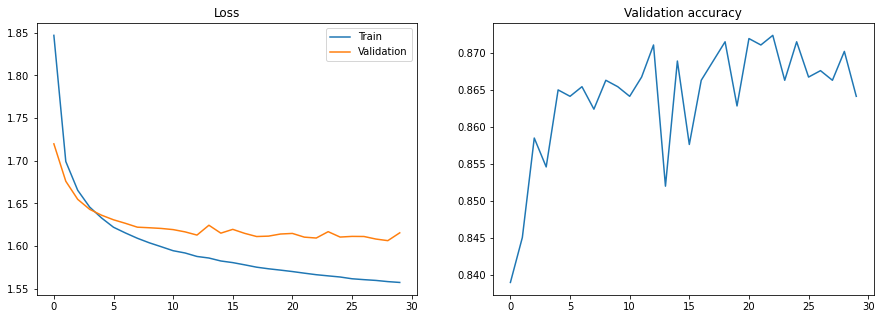

In [35]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [36]:
# Create the model again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 30 of 30 took 0.131s
	Training loss: 1.497492
	Validation loss: 1.550785
	Validation accuracy: 0.904


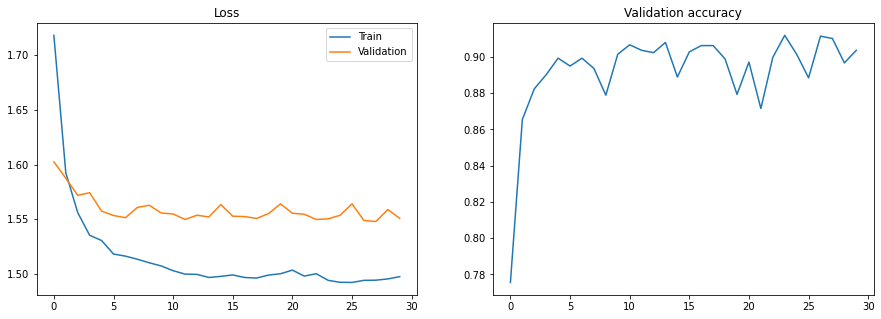

In [38]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [39]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(p=0.85),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(p=0.85),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [40]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 30 of 30 took 0.134s
	Training loss: 0.707472
	Validation loss: 0.365604
	Validation accuracy: 0.888


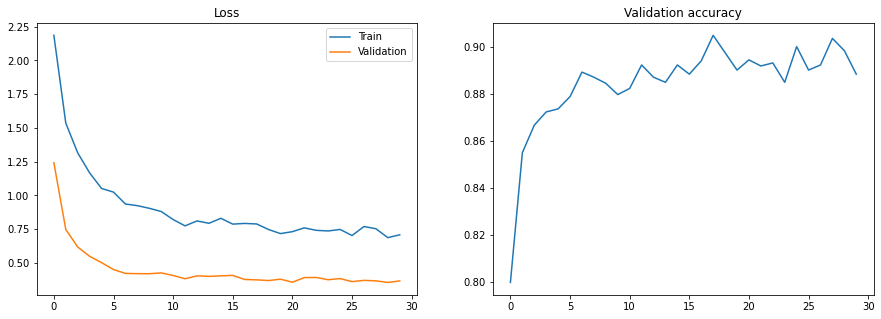

In [41]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

In [42]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.BatchNorm1d(500),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 30 of 30 took 0.166s
	Training loss: 0.009729
	Validation loss: 0.475021
	Validation accuracy: 0.915


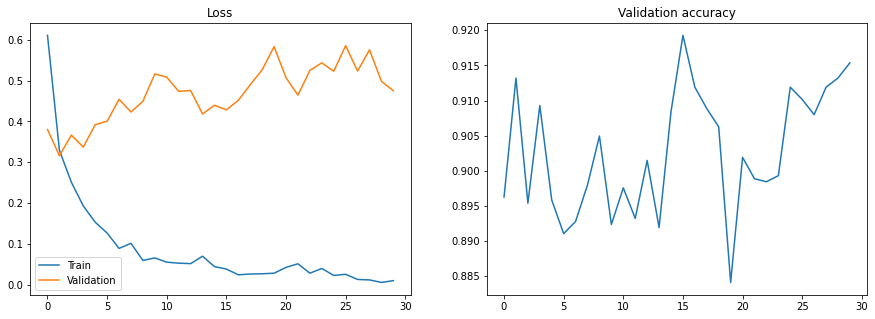

In [44]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Task 3: Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [45]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states
    #   and hyperparameters used.
    state = {
        "state_dict": model.state_dict(),
        "optimizer" : optimizer.state_dict()
    }
    torch.save(state, checkpoint_path)
    print(f"Model saved to {checkpoint_path}")


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print(f"Model loaded from {checkpoint_path}")

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = model = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Dropout(p=0.85),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(p=0.85),
            nn.Linear(200, 10),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.model(x)

In [47]:
def test():
    n_epochs = 30

    train_loss, val_loss, val_accuracy = train_model(
        model, train_loader, val_loader, loss_func, optimizer, n_epochs
    )

    plot_train_process(train_loss, val_loss, val_accuracy)

Epoch 30 of 30 took 0.118s
	Training loss: 0.682601
	Validation loss: 0.373958
	Validation accuracy: 0.885


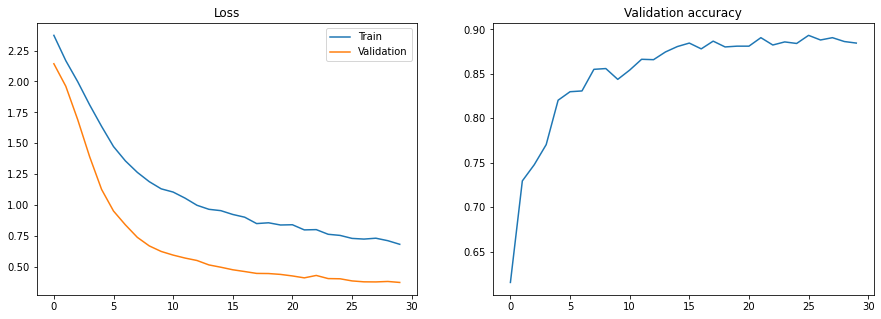

In [48]:
# Create a brand new model:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Testing. You should get a pretty poor performance
# since the model hasn't learned anything yet:
test()

#### Define a training loop with model checkpointing

In [49]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()

    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

Epoch 30 of 30 took 0.118s
	Training loss: 0.285965
	Validation loss: 0.405358
	Validation accuracy: 0.904
Model saved to mnist-470.pth


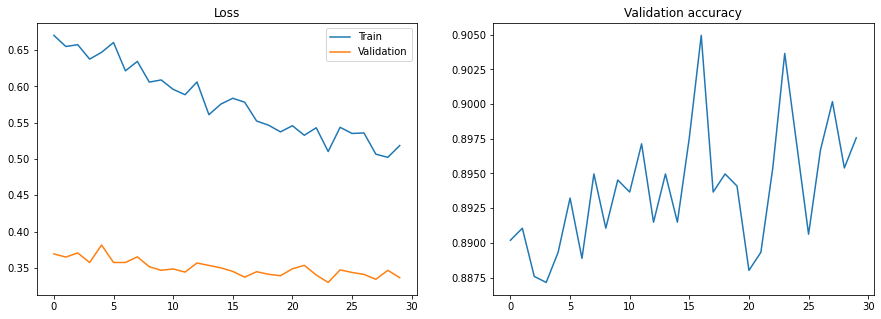

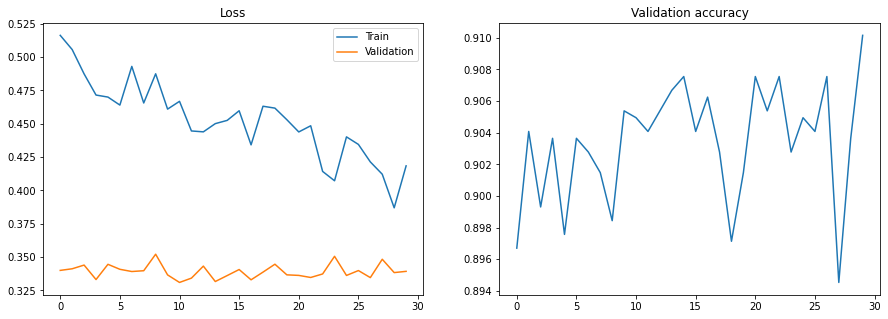

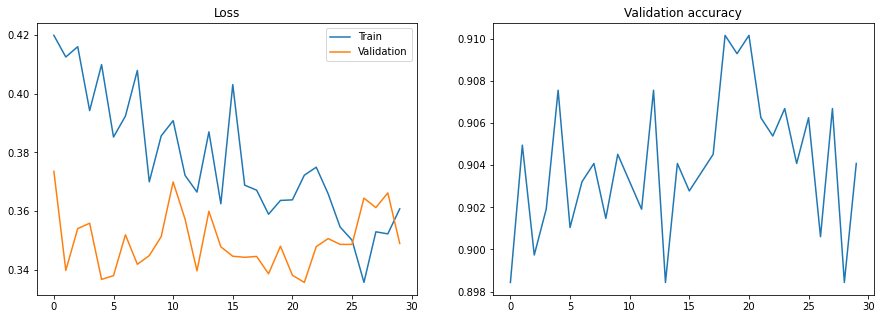

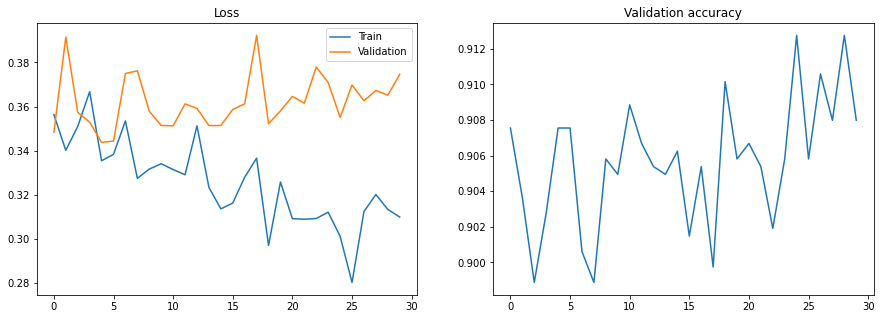

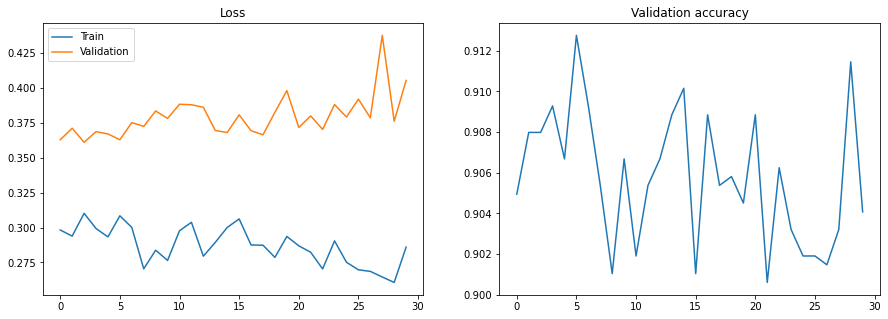

In [50]:
train_save(5, save_interval=500, log_interval=100)

Epoch 30 of 30 took 0.118s
	Training loss: 0.232401
	Validation loss: 0.398966
	Validation accuracy: 0.908


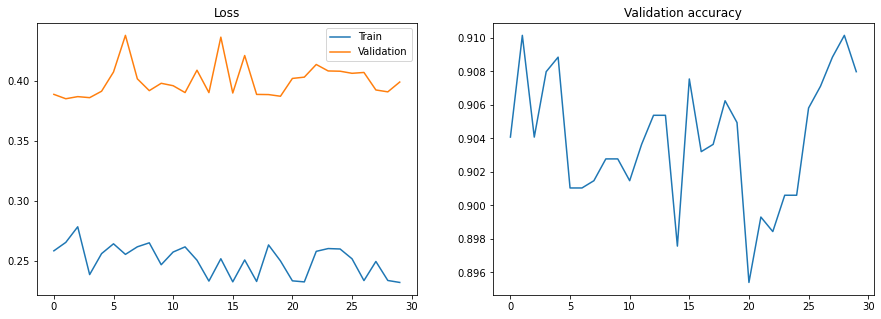

In [51]:
# Create new model
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load from the final checkpoint
load_checkpoint('mnist-470.pth', model, optimizer)

# Should give you the final model accuracy
test()

# More about PyTorch
* Using torch on GPU and multi-GPU ([link](http://pytorch.org/docs/master/notes/cuda.html)).
* More tutorials on PyTorch ([link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)).
* PyTorch examples: a repo that implements many cool DL models in pytorch ([link](https://github.com/pytorch/examples)).
* Practical PyTorch: a repo that implements some... other cool DL models... yes, in PyTorch ([link](https://github.com/spro/practical-pytorch)).
* And some more ([link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)).